In [57]:
import pandas as pd
from chromax import Simulator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "jax"

from typing import Dict, Any, List
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Lambda

import tensorflow as tf


In [61]:
def create_fake_geneticmap(number_markers:int):
    """The genetic map represents the rules of the game. It assigns the truth value to each marker.

    :param number_markers: the total number of markers to include in this genetic map. must correspond to population shape
    :type number_markers: int 
    """
    # 'chr' will always be '1A' for every marker
    chr_array = ['1A'] * number_markers
    
    # 'yield': Create a marker_strength array with 1 float between -0.5 and +0.5 randomly
    # yield_array = np.random.poisson(np.random.randint(1,10), size=number_markers)
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)

    # Scale the Poisson values to the range [0, 1]
    scaled_poisson_values = poisson_values / np.max(poisson_values)

    # Stretch and shift the values to the range [-1, 1]
    yield_array = (scaled_poisson_values * 2) - 1
    
    # 'cM': create an array for number_markers length evenly sampled between 0 and 100
    cM_array = np.linspace(0, 100, num=number_markers)
    
    # Create the DataFrame with the auto-generated data
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    
    return df

def create_fake_population(total_pops:int, number_individuals:int, number_markers:int, ploidy:int):
    """
        Creates a batch of populations. A populations is a group of individuals. An individual is composed of markers. Markers are 0 or 1

        Returns : binary array shape (total_pops, number_individuals, number_markers, ploidy)
    """
    # List of generation methods
    generation_methods = [
        lambda: np.random.randint(2, size=(number_individuals, number_markers, ploidy)),
        lambda: np.random.rand(number_individuals, number_markers, ploidy),
        lambda: np.random.standard_normal((number_individuals, number_markers, ploidy)),
        lambda: np.random.choice([0, 1], size=(number_individuals, number_markers, ploidy))
    ]
    
    populations = []
    for _ in range(total_pops):
        # Randomly select a generation method and generate the population
        gen_method = choice(generation_methods)
        population = gen_method()
        populations.append(population)
        
    # Combine all populations into a single numpy array
    combined_population = np.array(populations)
    return combined_population




def calculate_scores(population, marker_strength):
    """
    Calculates the additive score by matrix multipling the population (n,m) with the marker strengths (m,)
    """
    # Perform a dot product between the dosages and marker strength arrays
    dosages = np.sum(population,axis=2)
    scores = np.dot(dosages, marker_strength)
    return scores

def panmixia(selected_parents, total_offspring):
    """ Handles the random crossing for us ; heuristic!

    selected_parents ( n , m , d )
    
    """
    n, m, d = selected_parents.shape
    offspring_target = total_offspring
    offspring_list = []

    while len(offspring_list) < offspring_target:
        # Randomly pick two parents without replacement
        parents_indices = np.random.choice(n, size=2, replace=False)
        parent1, parent2 = selected_parents[parents_indices]

        # Simulate random recombination for each marker
        offspring = np.zeros((m, d), dtype=parent1.dtype)
        for i in range(m):
            # Randomly choose one allele from each parent for each marker
            for j in range(d):
                parent_allele = np.random.choice([parent1[i, j], parent2[i, j]])
                offspring[i, j] = parent_allele

        # Add the new offspring to the offspring list
        offspring_list.append(offspring)

    # Convert offspring list to a numpy array with shape (offspring_target, m, d)
    offspring_array = np.array(offspring_list)
    return offspring_array


def scores2parents(scores,K):
    """
    hint: use output from calculate_scores
    """
    # Specify the number of top values you want (K)
    K = 5

    # Get the indices that would sort the array
    sorted_indices = np.argsort(scores)

    # Take the last K indices of the sorted indices array
    top_k_indices = sorted_indices[-K:]

    # Since argsort returns indices in ascending order, reverse to get the top values
    top_k_indices = top_k_indices[::-1]

    print("Indices of top K values:", top_k_indices)
    print("Top K values:", scores[top_k_indices])

    return top_k_indices


def select_parents(policy, total_parents):
    """
        input: Policy from actor ( score or metric value for each individual )
        returns : index of parents to be included in random_crosses for next step of breeding program
    """
    values, indices = tf.math.top_k(policy, total_parents)
    return values,indices

def printshape(message , arr):
    print(f'{message} {arr.shape}')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def score2hist(score):
    #e.g. (3,50) array

    # Assuming 'data' is your (3,50) array
    data = score

    # Plot KDE for each row in the data
    for i in range(data.shape[0]):
        kde = gaussian_kde(data[i])
        dist_space = np.linspace(min(data[i]), max(data[i]), 100)
        plt.plot(dist_space, kde(dist_space), label=f'Distribution {i+1}')

    # Adding labels and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.title('population score distributions')

    # Show plot
    plt.show()


# Example usage:
number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3
initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
fraction_selection = 10

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Add
from tensorflow.keras import initializers

def create_actor_model(num_individual, num_markers, initializer='he_normal', use_skip_connection=False):
    # Define the initializer
    init = getattr(initializers, initializer)()
    
    # Define the input layers
    population_input = Input(shape=(num_individual, num_markers), name='population_input')
    phenotype_input = Input(shape=(num_individual, 1), name='phenotype_input')
    
    # Flatten the inputs
    flat_population = Flatten()(population_input)
    flat_phenotype = Flatten()(phenotype_input)
    
    # Combine inputs
    combined = concatenate([flat_population, flat_phenotype])
    
    # Define the hidden layers
    hidden1 = Dense(units=64, activation='relu', kernel_initializer=init)(combined)
    hidden2 = Dense(units=64, activation='relu', kernel_initializer=init)(hidden1)
    
    # Check if skip connection is to be used
    if use_skip_connection:
        # Transform phenotype input to match the shape of hidden2
        phenotype_transformed = Dense(units=64, activation='relu', kernel_initializer=init)(flat_phenotype)
        skip_connection = Add()([hidden2, phenotype_transformed])
        output = Dense(units=1, activation='sigmoid', kernel_initializer=init)(skip_connection)
    else:
        output = Dense(units=1, activation='sigmoid', kernel_initializer=init)(hidden2)
    
    # Create the model
    model = Model(inputs=[population_input, phenotype_input], outputs=output)
    
    return model


first pop shape (3, 50, 100, 2)
first score list shape (3, 50)


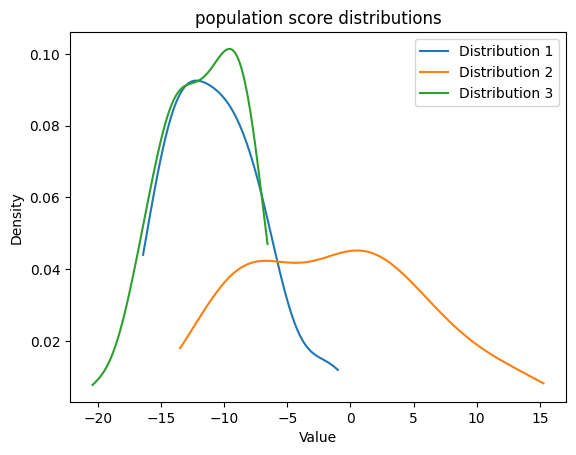

In [54]:
# Example usage:
number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3
initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
printshape('first pop shape' , initial_population)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
fraction_selection = 10

#score init pop
initial_score = np.array([calculate_scores(x,marker_strength) for x in initial_population])
printshape('first score list shape' , initial_score)

score2hist(initial_score)

In [55]:
agent1 = create_actor_model(number_individuals, number_markers, initializer='he_normal', use_skip_connection=False)
agent2 = create_actor_model(number_individuals, number_markers, initializer='he_normal', use_skip_connection=True)


/home/glect/breeder_agent/agent_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
